# Pull Halo Sample from Gaia eDR3-StarHorse Catalog
---

This notebook provides a tutorial on how to retrieve data from the combined Gaia eDR3 - StarHorse Catalog. The StarHorse catalog reference is Anders et al. (2019; [DOI:10.1051/0004-6361/202142369](https://ui.adsabs.harvard.edu/link_gateway/2022A&A...658A..91A/doi:10.1051/0004-6361/202142369)).  Additional information can be found here: https://data.aip.de/projects/starhorse2021.html. Note that the tutorials have been updated by me.

In [24]:
# Import requisite packages
import numpy as np
import matplotlib.pyplot as plt
import pyvo as vo
import pandas as pd

## Perform single query for data retrieval
* Activate TAP with anonymous user with the url:https://gaia.aip.de/tap 
  * GAIA@AIP is being accessed, which is a service provided by the Leibniz-Institute for Astrophysics Potsdam (AIP)
* If needed, add authorization header to vo session
  * The user token can be found as follows: gaia.aip.de->username->API token (use dropdown menu; user preferences)
  * **NOTE**: *the anonymous query does not require authorization token*
* Commence query with the TAP service

In [17]:
# Initiate TAP service (with anonymous user)
service = vo.dal.TAPService("https://gaia.aip.de/tap")
# vo.utils.http.session.headers['Authorization'] = 'Your Token '

In [ ]:
# Retrieve a "top 100000" data set 
# Highly-filtered StarHorse results obtained by requiring sh_outflag==“0000”.
# Various flags can be turned off and on; example: sh_outflag==“0%%%”. 

In [25]:
data_pull = service.search("select top 100000 * from gaiaedr3_contrib.starhorse where SH_OUTFLAG LIKE '0000' ")

In [29]:
# Convert data retrieved into df
df=data_pull.to_table().to_pandas()

Index(['source_id', 'dist05', 'dist16', 'dist50', 'dist84', 'dist95', 'av05',
       'av16', 'av50', 'av84', 'av95', 'teff16', 'teff50', 'teff84', 'logg16',
       'logg50', 'logg84', 'met16', 'met50', 'met84', 'mass16', 'mass50',
       'mass84', 'ag50', 'abp50', 'arp50', 'bprp0', 'mg0', 'xgal', 'ygal',
       'zgal', 'rgal', 'fidelity', 'bp_rp_excess_corr', 'sh_photoflag',
       'sh_outflag'],
      dtype='object')

<AxesSubplot:xlabel='bprp0', ylabel='mg0'>

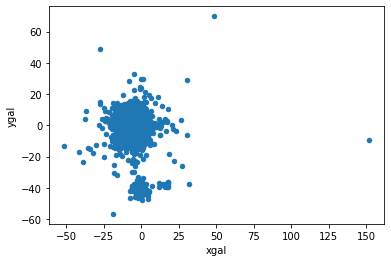

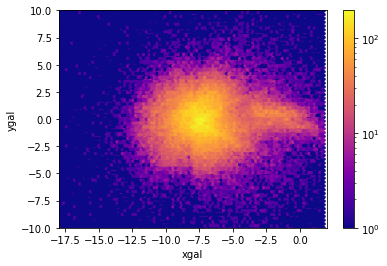

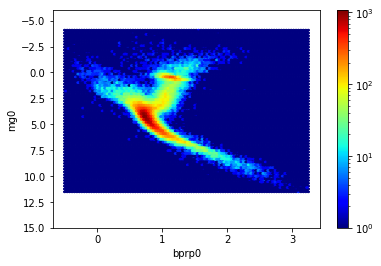

In [27]:
# Generate initial set of plots
df.plot(x='xgal',y='ygal',kind='scatter')
fig, ax = plt.subplots()
sel=(np.abs(df.xgal+8.2)<10)&(np.abs(df.ygal)<10)
df[sel].plot(x='xgal',y='ygal',kind='hexbin', xlim=(-18,2),ylim=(-10,10), norm=mpl.colors.LogNorm(),cmap="plasma",ax=ax)
fig, ax = plt.subplots()
df[sel].plot(x='bprp0',y='mg0',kind='hexbin', ylim=(15,-6), norm=mpl.colors.LogNorm(),cmap="jet", ax=ax)

## Perform batch/db chunking for data retrieval

In [ ]:
# Initiate tap service (with anonymous user)
tap_service = vo.dal.TAPService('https://gaia.aip.de/tap')
#vo.utils.http.session.headers['Authorization'] = 'Your Token '

In [ ]:
# Manage the jobs
jobs = []

limit = 100000
total = 1000000
qstr="select  source_id,xgal,ygal,zgal,rgal,ruwe,mg0,bprp0 from gaiaedr3_contrib.starhorse where SH_OUTFLAG LIKE '0000' "
i=0
for offset in range(0, total, limit):
    sql = qstr +' LIMIT %s OFFSET %s' % (limit, offset)
    print(sql)
    job =     tap_service.submit_job(sql, language='postgresql', runid='batch'+str(i))
    job.run()
    jobs.append(job)
    i=i+1

i=0
dfvec=[]

In [ ]:
# Collect all results
for job in jobs:
    print('getting results:',i)
    job.raise_if_error()
    results = job.fetch_result()
    dfvec.append(results.to_table().to_pandas())
    i=i+1
i=0

print('combining...')
df=pd.concat(dfvec)

## Retrieve a halo sample
For a sample of halo stars, employ the following (additional) sample criteria:
  * |b| > 15 deg
  * dist50 > 10 kpc